In [1]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


# 이전 CNN MNIST


In [2]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Input

import time

In [3]:
(raw_train_x, raw_train_y), (raw_test_x, raw_test_y) = tf.keras.datasets.mnist.load_data()

train_x = raw_train_x/255
test_x = raw_test_x/255

train_x = train_x.reshape((60000, 28, 28, 1))
test_x = test_x.reshape((10000, 28, 28, 1))

train_y = raw_train_y
test_y = raw_test_y

11493376/11490434 [==============================] - 0s 0us/step


In [ ]:
model = keras.Sequential()
model.add(Input((28,28,1)))
model.add(Conv2D(32, (3, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(10, activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dense(10, activation='softmax'))

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [ ]:
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
model.summary()


model.fit(train_x, train_y, epochs=5, verbose=1, batch_size=128)


loss, acc = model.evaluate(test_x, test_y)
print("loss=",loss)
print("acc=",acc)

y_ = model.predict(test_x)
predicted = np.argmax(y_, axis=1)

print(predicted)


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1600)              0         
_________________________________________________________________
dense (Dense)                (None, 10)                16010     
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1

# Functional API 타입 CNN MNIST

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Input

import time

In [5]:
# model = keras.Sequential()
# model.add(Input((28,28,1)))
# model.add(Conv2D(32, (3, 3)))
# model.add(MaxPooling2D((2, 2)))
# model.add(Conv2D(64, (3, 3)))
# model.add(MaxPooling2D((2, 2)))
# model.add(Flatten())
# model.add(Dense(10, activation='relu'))
# model.add(Dense(10, activation='relu'))
# model.add(Dense(10, activation='softmax'))

from tensorflow.keras import Model

input = Input((28,28,1))
x = Conv2D(32, (3,3))(input)
x = MaxPooling2D((2,2))(x)
x = Conv2D(32, (3,3))(x)
x = MaxPooling2D((2,2))(x)
x = Flatten()(x)
x = Dense(10, activation='relu')(x)
x = Dense(10, activation='relu')(x)
output = Dense(10, activation='softmax')(x)

model = Model(input, output)

In [6]:
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
model.summary()


model.fit(train_x, train_y, epochs=5, verbose=1, batch_size=128)


loss, acc = model.evaluate(test_x, test_y)
print("loss=",loss)
print("acc=",acc)

y_ = model.predict(test_x)
predicted = np.argmax(y_, axis=1)

print(predicted)

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 11, 11, 32)        9248      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 5, 5, 32)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 800)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                8010

# 다중 입력

copy from https://www.pyimagesearch.com/2019/02/04/keras-multiple-inputs-and-mixed-data/


## 데이터 준비

In [7]:
!git clone https://github.com/emanhamed/Houses-dataset

Cloning into 'Houses-dataset'...
remote: Enumerating objects: 2166, done.
remote: Total 2166 (delta 0), reused 0 (delta 0), pack-reused 2166
Receiving objects: 100% (2166/2166), 176.26 MiB | 11.49 MiB/s, done.
Resolving deltas: 100% (20/20), done.


```
Houses-dataset/
  Houses Dataset
    100_bathroom.jpg
    100_bedroom.jpg
    ...
    HousesInfo.txt
```

In [8]:
!head 'Houses-dataset/Houses Dataset/HousesInfo.txt'

4 4 4053 85255 869500
4 3 3343 36372 865200
3 4 3923 85266 889000
5 5 4022 85262 910000
3 4 4116 85266 971226
4 5 4581 85266 1249000
3 4 2544 85262 799000
4 5 5524 85266 1698000
3 4 4229 85255 1749000
4 5 3550 85262 1500000


In [9]:
# import the necessary packages
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import numpy as np
import glob
import cv2
import os

def load_house_attributes(inputPath):

	cols = ["bedrooms", "bathrooms", "area", "zipcode", "price"]
	df = pd.read_csv(inputPath, sep=" ", header=None, names=cols)
 
	# determine (1) the unique zip codes and (2) the number of data
	# points with each zip code
	zipcodes = df["zipcode"].value_counts().keys().tolist()
	counts = df["zipcode"].value_counts().tolist()
 
	# loop over each of the unique zip codes and their corresponding
	# count
	for (zipcode, count) in zip(zipcodes, counts):
		# the zip code counts for our housing dataset is *extremely*
		# unbalanced (some only having 1 or 2 houses per zip code)
		# so let's sanitize our data by removing any houses with less
		# than 25 houses per zip code
		if count < 25:
			idxs = df[df["zipcode"] == zipcode].index
			df.drop(idxs, inplace=True)
   
	# return the data frame
	return df

def process_house_attributes(df, train, test):
	# initialize the column names of the continuous data
	continuous = ["bedrooms", "bathrooms", "area"]

	# performin min-max scaling each continuous feature column to
	# the range [0, 1]
	cs = MinMaxScaler()
	trainContinuous = cs.fit_transform(train[continuous])
	testContinuous = cs.transform(test[continuous])
 
	# one-hot encode the zip code categorical data (by definition of
	# one-hot encoding, all output features are now in the range [0, 1])
	zipBinarizer = LabelBinarizer().fit(df["zipcode"])
	trainCategorical = zipBinarizer.transform(train["zipcode"])
	testCategorical = zipBinarizer.transform(test["zipcode"])
 
	# construct our training and testing data points by concatenating
	# the categorical features with the continuous features
	trainX = np.hstack([trainCategorical, trainContinuous])
	testX = np.hstack([testCategorical, testContinuous])
 
	# return the concatenated training and testing data
	return (trainX, testX)  

In [10]:
def load_house_images(df, inputPath):

	# initialize our images array (i.e., the house images themselves)
	images = []

	# loop over the indexes of the houses
	for i in df.index.values:
		# find the four images for the house and sort the file paths,
		# ensuring the four are always in the *same order*
		basePath = os.path.sep.join([inputPath, "{}_*".format(i + 1)])
		housePaths = sorted(list(glob.glob(basePath)))
  
		# initialize our list of input images along with the output image
		# after *combining* the four input images
		inputImages = []
		outputImage = np.zeros((64, 64, 3), dtype="uint8")
  
		# loop over the input house paths
		for housePath in housePaths:
			# load the input image, resize it to be 32 32, and then
			# update the list of input images
			image = cv2.imread(housePath)
			image = cv2.resize(image, (32, 32))
			inputImages.append(image)
   
		# tile the four input images in the output image such the first
		# image goes in the top-right corner, the second image in the
		# top-left corner, the third image in the bottom-right corner,
		# and the final image in the bottom-left corner
		outputImage[0:32, 0:32] = inputImages[0]
		outputImage[0:32, 32:64] = inputImages[1]
		outputImage[32:64, 32:64] = inputImages[2]
		outputImage[32:64, 0:32] = inputImages[3]

		# add the tiled image to our set of images the network will be
		# trained on
		images.append(outputImage)
  
	# return our set of images
	return np.array(images)  

### 값 정보 읽기

In [11]:
df = load_house_attributes("Houses-dataset/Houses Dataset/HousesInfo.txt")

In [12]:
df.head()

,bedrooms,bathrooms,area,zipcode,price
30,5,3.0,2520,93446,789000
32,3,2.0,1802,93446,365000
39,3,3.0,2146,93446,455000
80,4,2.5,2464,91901,599000
81,2,2.0,1845,91901,529800


### 영상 데이터 읽기

In [13]:
images = load_house_images(df, "Houses-dataset/Houses Dataset/")
images = images/255.

In [14]:
print(images.shape)

(362, 64, 64, 3)


In [18]:
from sklearn.model_selection import train_test_split

(trainAttrX, testAttrX, trainImagesX, testImagesX) = train_test_split(df, images, test_size=0.25, random_state=42)

maxPrice = trainAttrX["price"].max()
trainY = trainAttrX["price"] / maxPrice
testY = testAttrX["price"] / maxPrice
(trainAttrX, testAttrX) = process_house_attributes(df, trainAttrX, testAttrX)

In [19]:
print("tainAttrX.shape=", trainAttrX.shape)
print("trainImagesX.shape=", trainImagesX.shape)
print("trainY.shape=", trainY.shape)
print("testAttrX.shape=", testAttrX.shape)
print("testImageX.shape=", testImagesX.shape)
print("testY.shape=", testY.shape)

tainAttrX.shape= (271, 10)
trainImagesX.shape= (271, 64, 64, 3)
trainY.shape= (271,)
testAttrX.shape= (91, 10)
testImageX.shape= (91, 64, 64, 3)
testY.shape= (91,)


In [21]:
# import the necessary packages
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import concatenate

## 개별 모델로 학습 실행

### 속성 모델

In [22]:
input = Input(trainAttrX[0].shape)
x = Dense(10, activation='relu')(input)
x = Dense(10, activation='relu')(x)
output = Dense(1)(x)

attr_model = Model(input, output)

In [23]:
attr_model.compile(optimizer="adam", loss="mse")
attr_model.summary()

attr_model.fit(trainAttrX, trainY, epochs=100, verbose=0, batch_size=128)

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 10)]              0         
_________________________________________________________________
dense_6 (Dense)              (None, 10)                110       
_________________________________________________________________
dense_7 (Dense)              (None, 10)                110       
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 11        
Total params: 231
Trainable params: 231
Non-trainable params: 0
_________________________________________________________________


In [24]:
preds = attr_model.predict(testAttrX)

diff = preds.flatten() - testY
percentDiff = (diff / testY) * 100
absPercentDiff = np.abs(percentDiff)

mean = np.mean(absPercentDiff)
std = np.std(absPercentDiff)

print("[INFO] mean: {:.2f}%, std: {:.2f}".format(mean, std))

[INFO] mean: 32.87%, std: 44.22


### 영상 모델

In [25]:
input = Input(trainImagesX[0].shape)
x = Conv2D(32, (3,3))(input) #EunAh: CNN
x = MaxPooling2D((2,2))(x)
x = Conv2D(32, (3,3))(x)
x = MaxPooling2D((2,2))(x)
x = Flatten()(x)
x = Dense(10, activation='relu')(x)
x = Dense(10, activation='relu')(x)
output = Dense(1)(x)

image_model = Model(input, output)

In [26]:
image_model.compile(optimizer="adam", loss="mse")
image_model.summary()

image_model.fit(trainImagesX, trainY, epochs=100, verbose=0, batch_size=128)

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 62, 62, 32)        896       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 29, 29, 32)        9248      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 6272)              0         
_________________________________________________________________
dense_9 (Dense)              (None, 10)                6273

In [27]:
preds = image_model.predict(testImagesX)

diff = preds.flatten() - testY
percentDiff = (diff / testY) * 100
absPercentDiff = np.abs(percentDiff)

mean = np.mean(absPercentDiff)
std = np.std(absPercentDiff)

print("[INFO] mean: {:.2f}%, std: {:.2f}".format(mean, std))

[INFO] mean: 109.29%, std: 178.77


## 다중 입력 모델로 학습 실행

In [28]:
attr_input = Input(trainAttrX[0].shape)
x = Dense(10, activation='relu')(attr_input)
attr_out = Dense(10, activation='linear')(x) #출력만 없음 두개를 합친것

image_input = Input(trainImagesX[0].shape)
x = Conv2D(32, (3,3))(image_input)
x = MaxPooling2D((2,2))(x)
x = Conv2D(32, (3,3))(x)
x = MaxPooling2D((2,2))(x)
x = Flatten()(x)
x = Dense(10, activation='relu')(x)
image_output = Dense(10, activation='linear')(x)

combined_input = concatenate([attr_out, image_output]) #두개를 붙이고 

x = Dense(4, activation="relu")(combined_input) #히든레이어4개에 아랫칸에 출력
output = Dense(1)(x)


combined_model = Model([attr_input, image_input], output)

In [29]:
combined_model.compile(optimizer="adam", loss="mse")
combined_model.summary()

combined_model.fit([trainAttrX, trainImagesX], trainY, epochs=100, verbose=0, batch_size=128)

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 62, 62, 32)   896         input_6[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_6 (MaxPooling2D)  (None, 31, 31, 32)   0           conv2d_6[0][0]                   
__________________________________________________________________________________________________
conv2d_7 (Conv2D)               (None, 29, 29, 32)   9248        max_pooling2d_6[0][0]            
____________________________________________________________________________________________

In [30]:
preds = combined_model.predict([testAttrX, testImagesX])

diff = preds.flatten() - testY
percentDiff = (diff / testY) * 100
absPercentDiff = np.abs(percentDiff)

mean = np.mean(absPercentDiff)
std = np.std(absPercentDiff)

print("[INFO] mean: {:.2f}%, std: {:.2f}".format(mean, std))

[INFO] mean: 114.92%, std: 188.19


# 다중 출력

copy from https://www.pyimagesearch.com/2018/06/04/keras-multiple-outputs-and-multiple-losses/

## 데이터 준비

In [31]:
!wget https://github.com/dhrim/wiset_2020_06/raw/master/material/deep_learning/fashion_dataset.zip

--2020-06-24 05:34:57--  https://github.com/dhrim/wiset_2020_06/raw/master/material/deep_learning/fashion_dataset.zip
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/dhrim/wiset_2020_06/master/material/deep_learning/fashion_dataset.zip [following]
--2020-06-24 05:34:58--  https://raw.githubusercontent.com/dhrim/wiset_2020_06/master/material/deep_learning/fashion_dataset.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 26991216 (26M) [application/zip]
Saving to: ‘fashion_dataset.zip’

fashion_dataset.zip 100%[===================>]  25.74M  34.4MB/s    in 0.7s    

2020-06-24 05:34:59 (34.4 MB/s) - 

In [34]:
!ls -alh

total 26M
drwxr-xr-x 1 root root 4.0K Jun 24 05:35 .
drwxr-xr-x 1 root root 4.0K Jun 24 05:04 ..
drwxr-xr-x 1 root root 4.0K Jun 19 16:15 .config
drwxr-xr-x 9 root root 4.0K Jun 23 11:22 fashion_dataset
-rw-r--r-- 1 root root  26M Jun 24 05:34 fashion_dataset.zip
drwxr-xr-x 4 root root 4.0K Jun 24 05:19 Houses-dataset
drwxrwxr-x 3 root root 4.0K Jun 23 11:27 __MACOSX
drwxr-xr-x 1 root root 4.0K Jun 17 16:18 sample_data


In [32]:
!unzip fashion_dataset.zip

Archive:  fashion_dataset.zip
   creating: fashion_dataset/
   creating: fashion_dataset/black_jeans/
  inflating: fashion_dataset/black_jeans/00000000.jpg  
   creating: __MACOSX/
   creating: __MACOSX/fashion_dataset/
   creating: __MACOSX/fashion_dataset/black_jeans/
  inflating: __MACOSX/fashion_dataset/black_jeans/._00000000.jpg  
  inflating: fashion_dataset/black_jeans/00000004.jpg  
  inflating: __MACOSX/fashion_dataset/black_jeans/._00000004.jpg  
  inflating: fashion_dataset/black_jeans/00000006.jpg  
  inflating: __MACOSX/fashion_dataset/black_jeans/._00000006.jpg  
  inflating: fashion_dataset/black_jeans/00000007.jpg  
  inflating: __MACOSX/fashion_dataset/black_jeans/._00000007.jpg  
  inflating: fashion_dataset/black_jeans/00000009.jpg  
  inflating: __MACOSX/fashion_dataset/black_jeans/._00000009.jpg  
  inflating: fashion_dataset/black_jeans/00000010.jpg  
  inflating: __MACOSX/fashion_dataset/black_jeans/._00000010.jpg  
  inflating: fashion_dataset/black_jeans/000000

In [35]:
import matplotlib

from keras.optimizers import Adam
from keras.preprocessing.image import img_to_array
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split

from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import random
import pickle
import cv2
import os

Using TensorFlow backend.


In [36]:
IMAGE_DIMS = (96, 96, 3)

### 영상 파일이름 읽기

In [37]:
imagePaths = sorted(list(paths.list_images('fashion_dataset')))
random.shuffle(imagePaths)
print(len(imagePaths))
print(imagePaths[:3])

755
['fashion_dataset/red_dress/00000181.jpg', 'fashion_dataset/black_shoes/00000019.jpg', 'fashion_dataset/blue_dress/00000088.jpg']


### 영상 읽기, 카테고리와 컬러 읽기

In [38]:
data = []
categoryLabels = []
colorLabels = []

for imagePath in imagePaths:
	image = cv2.imread(imagePath)
	image = cv2.resize(image, (IMAGE_DIMS[1], IMAGE_DIMS[0]))
	image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
	image = img_to_array(image)
	data.append(image)

	(color, cat) = imagePath.split(os.path.sep)[-2].split("_")
  # imagePath = 'fashion_dataset/black_shoes/00000048.jpg'
  # color = 'black'
  # cat = 'shoes'
	categoryLabels.append(cat)
	colorLabels.append(color)

755 755 755
iamgePaths[0]= fashion_dataset/red_dress/00000181.jpg


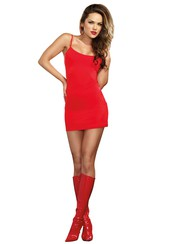

data[0]= (96, 96, 3)
categoryLabels[0]= dress
colorLabels[0]= red


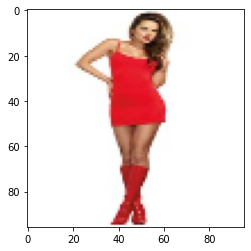

In [39]:
from IPython.display import Image, display

print(len(data), len(categoryLabels), len(colorLabels))
print("iamgePaths[0]=", imagePaths[0])
display(Image(imagePaths[0]))

print("data[0]=", data[0].shape)
plt.imshow(data[0]/255)
print("categoryLabels[0]=", categoryLabels[0])
print("colorLabels[0]=", colorLabels[0])

### numpy로 변환

In [40]:
data = np.array(data, dtype="float")
print("[INFO] data matrix: {} images ({:.2f}MB)".format(len(imagePaths), data.nbytes / (1024 * 1000.0)))

# convert the label lists to NumPy arrays prior to binarization
categoryLabels = np.array(categoryLabels)
colorLabels = np.array(colorLabels)

[INFO] data matrix: 755 images (163.08MB)


## normalization

In [41]:
data = data/255.

### 레이블 데이터를 one-hot 인코딩

In [42]:
print(categoryLabels[:5])
print(colorLabels[:5])

categoryLB = LabelBinarizer()
categoryLabels = categoryLB.fit_transform(categoryLabels)

colorLB = LabelBinarizer()
colorLabels = colorLB.fit_transform(colorLabels)

print(categoryLabels[:3])
print(colorLabels[:3])

['dress' 'shoes' 'dress' 'jeans' 'shirt']
['red' 'black' 'blue' 'black' 'blue']
[[1 0 0 0]
 [0 0 0 1]
 [1 0 0 0]]
[[0 0 1]
 [1 0 0]
 [0 1 0]]


### 데이터 분리

In [43]:
(trainX, testX, trainCategoryY, testCategoryY, trainColorY, testColorY) = train_test_split(data, categoryLabels, colorLabels, test_size=0.2, random_state=42)

print(trainX.shape)
print(trainCategoryY.shape)
print(trainColorY.shape)

print(testX.shape)
print(testCategoryY.shape)
print(testColorY.shape)

(604, 96, 96, 3)
(604, 4)
(604, 3)
(151, 96, 96, 3)
(151, 4)
(151, 3)


In [44]:
CATEGORY_COUNT = categoryLabels.shape[-1]
COLOR_COUNT = colorLabels.shape[-1]

print(CATEGORY_COUNT)
print(COLOR_COUNT)

4
3


## 개별 모델로 학습 실행

In [45]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Input


def build_category_model():

  model = keras.Sequential()
  model.add(Input(IMAGE_DIMS))
  model.add(Conv2D(32, (3, 3)))
  model.add(MaxPooling2D((2, 2)))
  model.add(Conv2D(64, (3, 3)))
  model.add(MaxPooling2D((2, 2)))
  model.add(Flatten())
  model.add(Dense(10, activation='relu'))
  model.add(Dense(10, activation='relu'))
  model.add(Dense(CATEGORY_COUNT, activation='softmax'))

  return model

def build_color_model():

  model = keras.Sequential()
  model.add(Input(IMAGE_DIMS))
  model.add(Conv2D(32, (3, 3)))
  model.add(MaxPooling2D((2, 2)))
  model.add(Conv2D(64, (3, 3)))
  model.add(MaxPooling2D((2, 2)))
  model.add(Flatten())
  model.add(Dense(10, activation='relu'))
  model.add(Dense(10, activation='relu'))
  model.add(Dense(COLOR_COUNT, activation='softmax'))

  return model  

In [46]:
print(trainX.shape)
print(trainCategoryY.shape)
print(CATEGORY_COUNT)

(604, 96, 96, 3)
(604, 4)
4


### 카테고리 모델

In [47]:
category_model = build_category_model()

category_model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
category_model.summary()


category_model.fit(trainX, trainCategoryY, epochs=5, verbose=1, batch_size=128)


loss, acc = category_model.evaluate(testX, testCategoryY)
print("loss=",loss)
print("acc=",acc)


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 94, 94, 32)        896       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 47, 47, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 22, 22, 64)        0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 30976)             0         
_________________________________________________________________
dense_18 (Dense)             (None, 10)                309770    
_________________________________________________________________
dense_19 (Dense)             (None, 10)                1

### 컬러 모델

In [48]:
print(trainX.shape)
print(trainColorY.shape)
print(COLOR_COUNT)

(604, 96, 96, 3)
(604, 3)
3


In [49]:
color_model = build_color_model()

color_model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
color_model.summary()


color_model.fit(trainX, trainColorY, epochs=5, verbose=1, batch_size=128)


loss, acc = color_model.evaluate(testX, testColorY)
print("loss=",loss)
print("acc=",acc)


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 94, 94, 32)        896       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 47, 47, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 22, 22, 64)        0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 30976)             0         
_________________________________________________________________
dense_21 (Dense)             (None, 10)                309770    
_________________________________________________________________
dense_22 (Dense)             (None, 10)               

## 다중 출력 모델로 학습 실행

In [50]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import optimizers, Model
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Input


def build_category_branch(input):

  x = Conv2D(32, (3, 3))(input)
  x = MaxPooling2D((2, 2))(x)
  x = Conv2D(64, (3, 3))(x)
  x = MaxPooling2D((2, 2))(x)
  x = Flatten()(x)
  x = Dense(10, activation='relu')(x)
  x = Dense(10, activation='relu')(x)
  x = Dense(CATEGORY_COUNT, activation='softmax', name='category_output')(x)

  return x

def build_color_branch(input):

  x = Conv2D(32, (3, 3))(input)
  x = MaxPooling2D((2, 2))(x)
  x = Conv2D(64, (3, 3))(x)
  x = MaxPooling2D((2, 2))(x)
  x = Flatten()(x)
  x = Dense(10, activation='relu')(x)
  x = Dense(10, activation='relu')(x)
  x = Dense(COLOR_COUNT, activation='softmax', name='color_output')(x)

  return x

In [51]:
input = Input(IMAGE_DIMS)

category_output = build_category_branch(input)
color_output = build_color_branch(input)

multi_output_model = Model(input, [category_output, color_output])

multi_output_model.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 96, 96, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_12 (Conv2D)              (None, 94, 94, 32)   896         input_9[0][0]                    
__________________________________________________________________________________________________
conv2d_14 (Conv2D)              (None, 94, 94, 32)   896         input_9[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_12 (MaxPooling2D) (None, 47, 47, 32)   0           conv2d_12[0][0]                  
____________________________________________________________________________________________

In [52]:
losses = { "category_output":"categorical_crossentropy", "color_output":"categorical_crossentropy"} #모델에서 define 해준 이름
loss_weights = { "category_output":1.0, "color_output":1.0}

# color_model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
multi_output_model.compile(optimizer="adam", loss=losses, loss_weights=loss_weights, metrics=["accuracy"])


# color_model.fit(trainX, trainColorY, epochs=5, verbose=1, batch_size=128)
multi_output_model.fit(trainX, {"category_output":trainCategoryY, "color_output":trainColorY}, epochs=5, verbose=1, batch_size=128)

Train on 604 samples
Epoch 1/5
604/604 [==============================] - 1s 1ms/sample - loss: 2.7008 - category_output_loss: 1.4760 - color_output_loss: 1.2068 - category_output_acc: 0.3013 - color_output_acc: 0.4570
Epoch 2/5
604/604 [==============================] - 1s 838us/sample - loss: 2.1417 - category_output_loss: 1.2778 - color_output_loss: 0.8554 - category_output_acc: 0.3775 - color_output_acc: 0.6076
Epoch 3/5
604/604 [==============================] - 0s 816us/sample - loss: 1.4901 - category_output_loss: 1.0543 - color_output_loss: 0.4328 - category_output_acc: 0.5050 - color_output_acc: 0.7268
Epoch 4/5
604/604 [==============================] - 0s 817us/sample - loss: 1.2367 - category_output_loss: 0.8952 - color_output_loss: 0.3298 - category_output_acc: 0.5844 - color_output_acc: 0.8212
Epoch 5/5
604/604 [==============================] - 0s 810us/sample - loss: 1.0634 - category_output_loss: 0.7912 - color_output_loss: 0.2648 - category_output_acc: 0.6755 - color_

In [53]:
loss, category_loss, color_loss, category_acc, color_acc = multi_output_model.evaluate(testX, {"category_output":testCategoryY, "color_output":testColorY})
print("loss=",loss)
print("categoyr_loss=", category_loss)
print("color_loss=", color_loss)
print("category_acc=", category_acc)
print("color_acc=", color_acc)

151/151 [==============================] - 0s 1ms/sample - loss: 1.0310 - category_output_loss: 0.7662 - color_output_loss: 0.2635 - category_output_acc: 0.6225 - color_output_acc: 0.8609
loss= 1.0310248957564498
categoyr_loss= 0.7661644
color_loss= 0.2635234
category_acc= 0.6225166
color_acc= 0.86092716
